# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [Google Cloud Platform BigQuery](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table)

Context:

This dataset contains the credit card default for clients in Taiwan from April 2005 to September 2005

1) `limit_balance`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
2) `sex`: Gender (1=male, 2=female)
3) `education_level`: Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
4) `marital_status`: Marital status (1=married, 2=single, 3=others)
5) `age`: Age in years
6) `pay_0`: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
7) `pay_2`: Repayment status in August, 2005 (scale same as above)
8) `pay_3`: Repayment status in July, 2005 (scale same as above)
9) `pay_4`: Repayment status in June, 2005 (scale same as above)
10) `pay_5`: Repayment status in May, 2005 (scale same as above)
11) `pay_6`: Repayment status in April, 2005 (scale same as above)
12) `bill_amt_1`: Amount of bill statement in September, 2005 (NT dollar)
13) `bill_amt_2`: Amount of bill statement in August, 2005 (NT dollar)
14) `bill_amt_3`: Amount of bill statement in July, 2005 (NT dollar)
15) `bill_amt_4`: Amount of bill statement in June, 2005 (NT dollar)
16) `bill_amt_5`: Amount of bill statement in May, 2005 (NT dollar)
17) `bill_amt_6`: Amount of bill statement in April, 2005 (NT dollar)
18) `pay_amt_1`: Amount of previous payment in September, 2005 (NT dollar)
19) `pay_amt_2`: Amount of previous payment in August, 2005 (NT dollar)
20) `pay_amt_3`: Amount of previous payment in July, 2005 (NT dollar)
21) `pay_amt_4`: Amount of previous payment in June, 2005 (NT dollar)
22) `pay_amt_5`: Amount of previous payment in May, 2005 (NT dollar)
23) `pay_amt_6`: Amount of previous payment in April, 2005 (NT dollar)
24) `default_payment_next_month`: Default payment (1=yes, 0=no)

### Objective

- To create a model to predict `default_payment_next_month`

### Problem Statement

- What features are going to be useful as predictors?

### Additional Information
We have more details of the dataset in this [discussion](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608)
- `education_level`: Education Level (1=graduate school, 2=university, 3=high school, 0,4,5,6=others)
- `marital_status`: Marital status (1=married, 2=single, 3=divorce, 0=others)
- `pay_0` to `pay_6`: (2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.)

### Data Collection

We first need to query our data from GCP's BiqQuery using this code

```SQL
SELECT
  limit_balance,
  sex,
  education_level,
  marital_status,
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  pay_5,
  pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 21923
```

# 2. Importing Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from pathlib import Path

from pandas_profiling import ProfileReport

import joblib

import warnings
warnings.filterwarnings('ignore')

# For Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Classification Problems
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler

# Evaluate Classification Models
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc


pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='deep')

%matplotlib inline

ModuleNotFoundError: No module named 'pandas_profiling'

### Useful Functions

In [ ]:
def check_unique(data, col_type='both'):
    """
    Count the number of unique values in each features for 'numeric', 'categorical', or 'both'

    Parameters
    ----------
    data : DataFrame

    col_type : str
        The type of the column to filter. Either 'number', 'object', or 'both'

    Returns
    -------
    DataFrame
        Number of unique values of each features
    """

    # check if the column type is valid
    if col_type not in ('number', 'object', 'both'):
        raise ValueError('col_type must be either "number", "object", or "both"')

    # create a list if the column type is 'both'
    if col_type == 'both':
        col_type = ['number', 'object']

    # get the number of unique values in each column
    data_unique_count = pd.DataFrame.from_records(
        [(col, data[col].nunique()) for col in data.select_dtypes(include=col_type).columns],
        columns=['feats', 'num_unique']
    )

    return data_unique_count

In [ ]:
def find_normal_boundaries(data, variable):
    """
    Calculate the boundaries outside which sit the outliers for a Gaussian distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    upper_boundary = data[variable].mean() + 3 * data[variable].std()
    lower_boundary = data[variable].mean() - 3 * data[variable].std()

    return upper_boundary, lower_boundary

In [ ]:
def find_skewed_boundaries(data, variable, distance):
    """
    Calculate the boundaries outside which sit the outliers for skewed distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    distance : float
        The distance multiplier of IQR to calculate the boundaries

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)
    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)

    return upper_boundary, lower_boundary

In [ ]:
def check_dist(data):
    """
    Check the Skewness and Distribution for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Skewness and distribution types of each features
    """

    # create a DataFrame containing the features of the dataset and their respective skewness
    data_skewness = pd.DataFrame(data.skew(), columns=['skew']).reset_index()

    # reset the index and make the features columns
    data_skewness = data_skewness.rename(columns={'index': 'feats'})

    # create a new column to describe whether the feature in the dataset is normal or skewed
    data_skewness['dist'] = np.where(
        (data_skewness['skew'] > -0.5) & (data_skewness['skew'] < 0.5),
        'normal',
        'skewed'
    )

    return data_skewness

In [ ]:
def check_outlier(data, distance=1.5):
    """
    Check the outlier info for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Outlier infos such as upper and lower boundary, and also the number of outliers for each features
    """

    if distance not in (1.5, 3):
        raise ValueError('Parameter distance only accepts numeric value of either 1.5 or 3')

    data_skewness = check_dist(data)

    # create a dictionary to store the outlier infos
    data_outlier = {
        'feats': [],
        'upper_bound': [],
        'lower_bound': [],
        'tot_right_tail': [],
        'tot_left_tail': [],
        'tot_right_tail_pct': [],
        'tot_left_tail_pct': [],
        'tot_outlier': [],
        'tot_outlier_pct': [],
    }

    # loop over each row in the `skewness` DataFrame
    # calculate each features upper and lower boundaries and the outlier percentage
    for row in data_skewness.index:
        col = data_skewness.iloc[row]['feats']

        if data_skewness.iloc[row]['dist'] == 'normal':
            upper_bound, lower_bound = find_normal_boundaries(data, col)
        else:
            upper_bound, lower_bound = find_skewed_boundaries(data, col, distance)

        tot_right_tail = len(data[data[col] > upper_bound])
        tot_left_tail = len(data[data[col] < lower_bound])
        tot_right_tail_pct = tot_right_tail / len(data) * 100
        tot_left_tail_pct = tot_left_tail / len(data) * 100
        tot_outlier =  tot_right_tail + tot_left_tail
        tot_outlier_pct = tot_right_tail_pct + tot_left_tail_pct

        data_outlier['feats'].append(col)
        data_outlier['upper_bound'].append(upper_bound)
        data_outlier['lower_bound'].append(lower_bound)
        data_outlier['tot_right_tail'].append(tot_right_tail)
        data_outlier['tot_left_tail'].append(tot_left_tail)
        data_outlier['tot_right_tail_pct'].append(tot_right_tail_pct)
        data_outlier['tot_left_tail_pct'].append(tot_left_tail_pct)
        data_outlier['tot_outlier'].append(tot_outlier)
        data_outlier['tot_outlier_pct'].append(tot_outlier_pct)
    
    data_outlier = pd.DataFrame(data_outlier)

    return data_outlier

In [ ]:
def outlier_summary(data, distance=1.5):
    """
    Check the summary for outlier data, such as distribution and number of outliers for each features

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Summary of outlier such as distribution and number of outliers for each features
    """

    data_skewness = check_dist(data)
    data_outlier = check_outlier(data, distance)

    outlier_summary_cols = ['feats', 'skew', 'dist', 'tot_outlier', 'tot_outlier_pct']

    data_outlier_summary = pd.merge(data_skewness, data_outlier, on=['feats'])
    data_outlier_summary = data_outlier_summary[outlier_summary_cols]

    return data_outlier_summary

In [ ]:
def impute_na(data, variable, mean_value, median_value):
  """
  Function to Fill Missing Values with Zeroes, Mean, and Median
  """
  data[variable+'_mean'] = data[variable].fillna(mean_value)
  data[variable+'_median'] = data[variable].fillna(median_value)
  data[variable+'_zero'] = data[variable].fillna(0)
  
  return data

# 3. Data Loading

In [ ]:
# load dataset
df_ori = pd.read_csv('data/h8dsft_P1M1_nikki_satmaka.csv')
df = df_ori.copy()

# display the first 5 entries of the data
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000.0,1,1,2,39.0,0.0,0.0,0.0,0.0,0,...,50803.0,30789.0,15874.0,1800.0,2000.0,3000.0,2000.0,2000.0,2000.0,0
1,110000.0,2,1,2,29.0,0.0,0.0,0.0,0.0,0,...,32489.0,26354.0,20221.0,2000.0,2010.0,3000.0,3000.0,3000.0,1000.0,0
2,270000.0,1,1,2,36.0,0.0,0.0,0.0,2.0,0,...,40335.0,37165.0,22156.0,10076.0,4018.0,14.0,2051.0,2000.0,0.0,0
3,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
4,50000.0,1,1,2,24.0,0.0,0.0,0.0,0.0,0,...,19837.0,19855.0,20151.0,1367.0,1606.0,692.0,709.0,721.0,692.0,0


In [ ]:
# display the last 5 entries of the data
df.tail()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2960,210000.0,2,2,1,39.0,-1.0,-1.0,-1.0,-1.0,-2,...,0.0,0.0,12000.0,0.0,28428.0,0.0,0.0,12000.0,33664.0,0
2961,280000.0,2,1,1,41.0,2.0,-1.0,-1.0,-1.0,-2,...,0.0,0.0,244.0,6859.0,486.0,0.0,0.0,244.0,0.0,0
2962,80000.0,1,1,2,28.0,1.0,-1.0,-1.0,-1.0,-2,...,0.0,0.0,0.0,47.0,207.0,0.0,0.0,0.0,0.0,0
2963,200000.0,1,2,1,53.0,1.0,-1.0,-1.0,-2.0,-2,...,0.0,0.0,6753.0,2920.0,0.0,0.0,0.0,6753.0,0.0,1
2964,20000.0,2,1,2,24.0,-1.0,-1.0,-2.0,-2.0,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Data Understanding

In [ ]:
# check dataset shape
df.shape

(2965, 24)

There are 2965 entries and 24 columns of data

In [ ]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   int64  
 10  pay_6                       2965 non-null   int64  
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

All features have the data type number, which is either integer or float

In [ ]:
# check missing values in dataset
df.isna().sum().sort_values(ascending=False)

limit_balance                 0
sex                           0
pay_amt_6                     0
pay_amt_5                     0
pay_amt_4                     0
pay_amt_3                     0
pay_amt_2                     0
pay_amt_1                     0
bill_amt_6                    0
bill_amt_5                    0
bill_amt_4                    0
bill_amt_3                    0
bill_amt_2                    0
bill_amt_1                    0
pay_6                         0
pay_5                         0
pay_4                         0
pay_3                         0
pay_2                         0
pay_0                         0
age                           0
marital_status                0
education_level               0
default_payment_next_month    0
dtype: int64

Great there are no missing values

## Basic Characteristics of the Dataset

In [ ]:
# check basic stats for numerical features
df.describe(percentiles=[0.5]).T

,count,mean,std,min,50%,max
limit_balance,2965.0,1.63e+05,125030.42,10000.0,140000.0,8.00e+05
sex,2965.0,1.61e+00,0.49,1.0,2.0,2.00e+00
education_level,2965.0,1.85e+00,0.78,0.0,2.0,6.00e+00
marital_status,2965.0,1.56e+00,0.52,0.0,2.0,3.00e+00
age,2965.0,3.52e+01,9.11,21.0,34.0,6.90e+01
pay_0,2965.0,5.06e-03,1.11,-2.0,0.0,8.00e+00
pay_2,2965.0,-1.22e-01,1.18,-2.0,0.0,7.00e+00
pay_3,2965.0,-1.42e-01,1.18,-2.0,0.0,7.00e+00
pay_4,2965.0,-1.85e-01,1.18,-2.0,0.0,8.00e+00
pay_5,2965.0,-2.25e-01,1.16,-2.0,0.0,7.00e+00


In [ ]:
# check the cardinality of each nominal and ordinal features
for col in df.columns:
    if df[col].nunique() < 20:
        print(col, ':', df[col].nunique(), 'unique values, which contains', np.sort(df[col].unique()))

sex : 2 unique values, which contains [1 2]
education_level : 7 unique values, which contains [0 1 2 3 4 5 6]
marital_status : 4 unique values, which contains [0 1 2 3]
pay_0 : 11 unique values, which contains [-2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.]
pay_2 : 10 unique values, which contains [-2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]
pay_3 : 9 unique values, which contains [-2. -1.  0.  2.  3.  4.  5.  6.  7.]
pay_4 : 10 unique values, which contains [-2. -1.  0.  2.  3.  4.  5.  6.  7.  8.]
pay_5 : 9 unique values, which contains [-2 -1  0  2  3  4  5  6  7]
pay_6 : 8 unique values, which contains [-2 -1  0  2  3  4  6  7]
default_payment_next_month : 2 unique values, which contains [0 1]


Let's cover some basic stats of some columns in the dataset.
- `limit_balance`
    - Amount of given credit in NT dollars (includes individual and family/supplementary credit
    - The limit ranges from 10,000 NTD to 800,000 NTD, this is so huge
    - There is a quite huge gap between the mean and the median
    - The data might be right-skewed
    - Numerical feature
- `sex`
    - Gender (1=male, 2=female)
    - It seems there are more females compared to males as the median leans towards the label 2
    - Nominal feature
- `education_level`
    - Education Level (1=graduate school, 2=university, 3=high school, 0,4,5,6=others)
    - We have separate values for the label 'others'
    - I'm going to combine these into one value
    - Ordinal feature
    - It's weird that the labeling is formed in a descending order
    - I'm going to reverse the labeling to (1=others, 2=high school, 3=university, 4=graduate school)
    - This is in assumption that `others` mean didn't even graduate high school, which is lower than the other three labels
- `marital_status`
    - Marital status (1=married, 2=single, 3=divorce, 0=others)
    - To make it consistent with `education_level`, I'm going to replace `0` as `4`
    - Nominal feature
- `age`
    - The youngest age is 21 years old and the oldest is 69 years old
    - Numerical feature
- `pay_0` , `pay_2` , `pay_3` , `pay_4` , `pay_5` , `pay_6`
    - Repayment status in month of September 2005 , August 2005 , July 2005 , June 2005 , May 2005 , April 2005 respectively
    - Scale (2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.)
    - The feature `pay_0` should be named `pay_1` to be consistent with `bill_amt_1` and `pay_amt_1`
    - Ordinal categorical
- `bill_amt_1` , `bill_amt_2` , `bill_amt_3` , `bill_amt_4` , `bill_amt_5` , `bill_amt_6`
    - Amount of bill statement in September 2005 , August 2005 , July 2005 , June 2005 , May 2005 , April 2005 respectively
    - Numerical feature
- `pay_amt_1` , `pay_amt_2` , `pay_amt_3` , `pay_amt_4` , `pay_amt_5` , `pay_amt_6`
    - Amount of previous payment in September 2005 , August 2005 , July 2005 , June 2005 , May 2005 , April 2005 respectively
    - Numerical feature
- `default_payment_next_month`
    - Default payment (1=yes, 0=no)
    - Default is a situation in which the client cannot pay back a loan
    - This is the status of default for the clients next month
    - This feature name is too long and I'm going to shorten it
    - Our target

## Data Preparation

Handle cardinality in `education_level`, `marital_status` and also rename `pay_0` to `pay_1`

In [ ]:
# create a mapping to change the order of the labels
# others (previously 0, 4, 5, 6) are mapped to 1
# high school (previously 3) is mapped to 2
# university (previously 2) is mapped to 3
# graduate school (previously 1) is mapped to 4
education_map = {
    0: 1,
    1: 4,
    2: 3,
    3: 2,
    4: 1,
    5: 1,
    6: 1
}

# apply the education_map to the education_level column
df['education_level'] = df['education_level'].map(education_map)

# replace 0 in marital_status column with 4
df['marital_status'] = df['marital_status'].replace(0, 4)


# rename the feature `pay_0` to `pay_1`
df = df.rename({'pay_0': 'pay_1', 'default_payment_next_month': 'def_pay'}, axis=1)

In [ ]:
# check the cardinality of each nominal and ordinal features after cleaning
for col in df.columns:
    if df[col].nunique() < 20:
        print(col, ':', df[col].nunique(), 'unique values, which contains', np.sort(df[col].unique()))

sex : 2 unique values, which contains [1 2]
education_level : 4 unique values, which contains [1 2 3 4]
marital_status : 4 unique values, which contains [1 2 3 4]
pay_1 : 11 unique values, which contains [-2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.]
pay_2 : 10 unique values, which contains [-2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]
pay_3 : 9 unique values, which contains [-2. -1.  0.  2.  3.  4.  5.  6.  7.]
pay_4 : 10 unique values, which contains [-2. -1.  0.  2.  3.  4.  5.  6.  7.  8.]
pay_5 : 9 unique values, which contains [-2 -1  0  2  3  4  5  6  7]
pay_6 : 8 unique values, which contains [-2 -1  0  2  3  4  6  7]
def_pay : 2 unique values, which contains [0 1]


Data looks good and is in accordance with the data design

## Check for Dataset Imbalance

Check whether the target variable of the dataset is balance

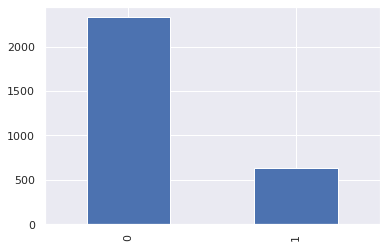

In [ ]:
# check for imbalance in target variable
df['def_pay'].value_counts().plot(kind='bar')
plt.show()

Since our dataset is imbalance, we need to stratify when splitting

## Splitting Dataset

We need to split the dataset into inference, train and test sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Sample data for inference

In [ ]:
# set random state
random_state = 42

In [ ]:
# sample dataset for inference
df_inf = df.sample(10, random_state=random_state)

# remove inference set from original dataset
df_train_test = df.drop(df_inf.index).reset_index(drop=True)

# reset index for inference set
df_inf = df_inf.reset_index(drop=True)

print('df_inf Size:', df_inf.shape)

df_inf Size: (10, 24)


### Split train and test set


Since the target variable is imbalanced, we use stratified sampling

In [ ]:
# we use stratified sampling to ensure that the distribution of the target variable is balanced
# we do not have a lot of data, so we use the test size of 0.15
df_train, df_test = train_test_split(
    df_train_test,
    test_size=0.15,
    random_state=random_state,
    stratify=df_train_test['def_pay']
)

print('df_train Size:', df_train.shape)
print('df_test Size:', df_test.shape)

df_train Size: (2511, 24)
df_test Size: (444, 24)


In [ ]:
# backup the train set that we are gonna perform EDA on
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

## Source of dataset

The dataset seems to have come from [UCI](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

## Number of clients that are default

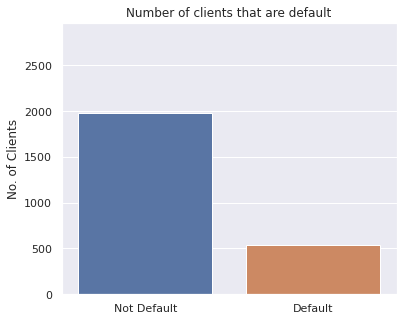

In [ ]:
# plot the number of clients that are default
plt.figure(figsize=(6,5))
ax = sns.countplot(data=df_train, x='def_pay')
plt.title('Number of clients that are default')
plt.xlabel(None)
plt.ylabel('No. of Clients')
plt.ylim(0, df.shape[0])
plt.xticks([0, 1], ['Not Default', 'Default'])

plt.show()

Most clients are not default the next month. There's around 1 to 4 ratio of clients who are default compared to ones who are not default

## Sex and Default

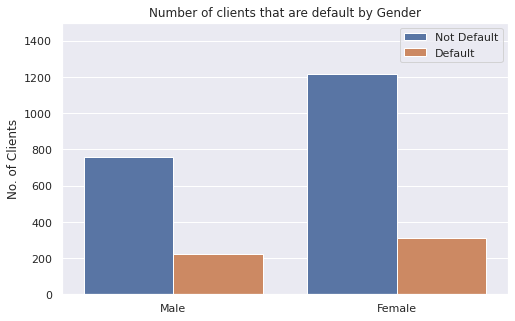

In [ ]:
# plot number of clients that are default by gender
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_train, x='sex', hue='def_pay')
plt.title('Number of clients that are default by Gender')
plt.xlabel(None)
plt.ylabel('No. of Clients')
plt.ylim(0, 1500)
plt.xticks([0, 1], ['Male', 'Female'])

plt.legend(labels=['Not Default', 'Default'])
plt.show()

There are more female clients compared to male clients

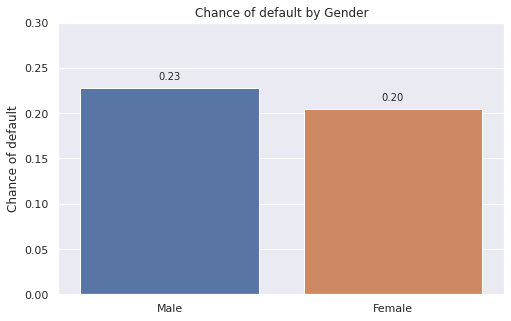

In [ ]:
# plot chance of default by gender
plt.figure(figsize=(8,5))
ax = sns.barplot(data=df_train, x='sex', y='def_pay', ci=None)
plt.title('Chance of default by Gender')
plt.xlabel(None)
plt.ylabel('Chance of default')
plt.ylim(0, 0.3)
plt.xticks([0, 1], ['Male', 'Female'])

for p in ax.patches:
    ax.annotate(f'{(p.get_height()):.2f}', (p.get_x() + 0.35, p.get_height() + 0.01))

plt.show()

However, male clients have a slightly higher chance of default

## Education Level and Default

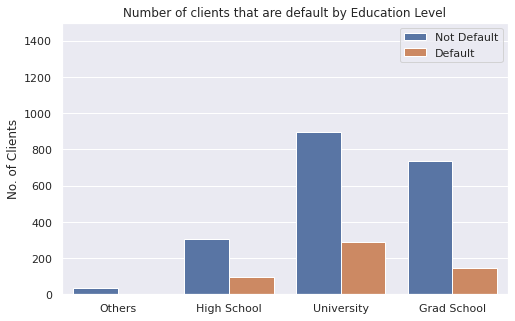

In [ ]:
# plot number of clients that are default by education level
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_train, x='education_level', hue='def_pay')
plt.title('Number of clients that are default by Education Level')
plt.xlabel(None)
plt.ylabel('No. of Clients')
plt.ylim(0, 1500)
plt.xticks([0, 1, 2, 3], ['Others', 'High School', 'University', 'Grad School'])

plt.legend(labels=['Not Default', 'Default'])
plt.show()

Most of our clients finished University and Grad School

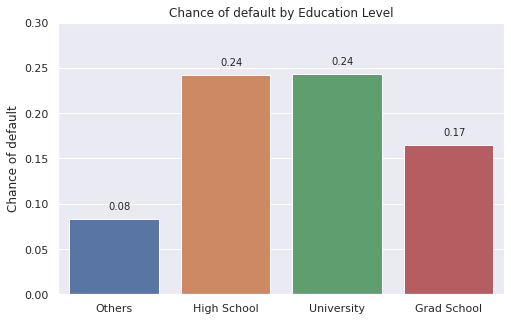

In [ ]:
# plot chance of default by education level
plt.figure(figsize=(8,5))
ax = sns.barplot(data=df_train, x='education_level', y='def_pay', ci=None)
plt.title('Chance of default by Education Level')
plt.xlabel(None)
plt.ylabel('Chance of default')
plt.ylim(0, 0.3)
plt.xticks([0, 1, 2, 3], ['Others', 'High School', 'University', 'Grad School'])

for p in ax.patches:
    ax.annotate(f'{(p.get_height()):.2f}', (p.get_x() + 0.35, p.get_height() + 0.01))

plt.show()

Looking at the graph, clients who attended Grad School, seems to have less chance of default compared to those who attended University or High School.\
The label for others also have a lower percentage of default, but this is also in conjunction that there are very few clients in this label, meaning the selection process to give out credit card to this label must be must be tight as well

## Marital Status

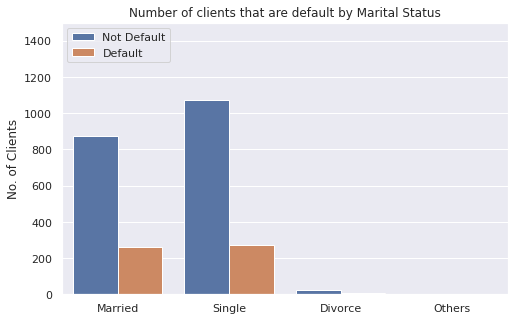

In [ ]:
# plot number of clients that are default by marital status
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_train, x='marital_status', hue='def_pay')
plt.title('Number of clients that are default by Marital Status')
plt.xlabel(None)
plt.ylabel('No. of Clients')
plt.ylim(0, 1500)
plt.xticks([0, 1, 2, 3], ['Married', 'Single', 'Divorce', 'Others'])

plt.legend(labels=['Not Default', 'Default'])
plt.show()

Most of our clients are either married or single

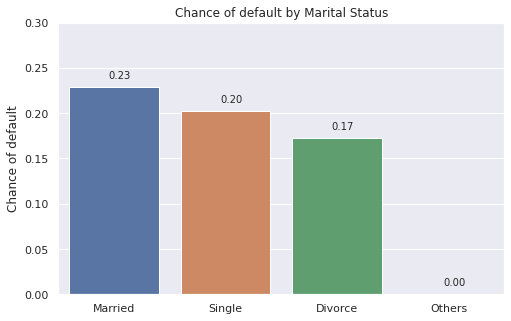

In [ ]:
# plot chance of default by marital status
plt.figure(figsize=(8,5))
ax = sns.barplot(data=df_train, x='marital_status', y='def_pay', ci=None)
plt.title('Chance of default by Marital Status')
plt.xlabel(None)
plt.ylabel('Chance of default')
plt.ylim(0, 0.3)
plt.xticks([0, 1, 2, 3], ['Married', 'Single', 'Divorce', 'Others'])

for p in ax.patches:
    ax.annotate(f'{(p.get_height()):.2f}', (p.get_x() + 0.35, p.get_height() + 0.01))

plt.show()

We can see that married people have a slightly higher chance of default, while divorced people have a lower chance of default, but there are only a few of them in the data, so this may not be enough to make a conclusion

## Age Distribution by Default Payment Status

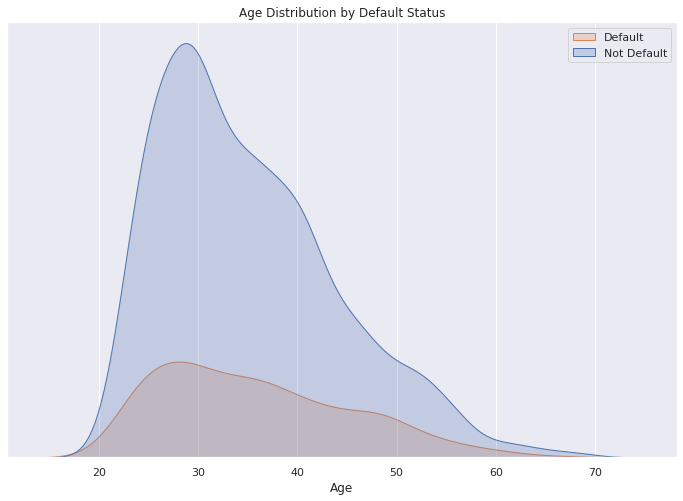

In [ ]:
# plot distribution of age by default status
sns.set(rc={'figure.figsize':(12,8)})
sns.kdeplot(data=df_train, x='age', hue='def_pay', shade=True)
plt.title('Age Distribution by Default Status')
plt.xlabel('Age')
plt.yticks([])
plt.ylabel(None)

plt.legend(labels=['Default', 'Not Default'])
plt.show()

We can see that the clients are mostly around the age of 30. There's not really any difference between the distribution between default and not default other than the sheer size

## Limit Balance Distribution by Default Payment Status

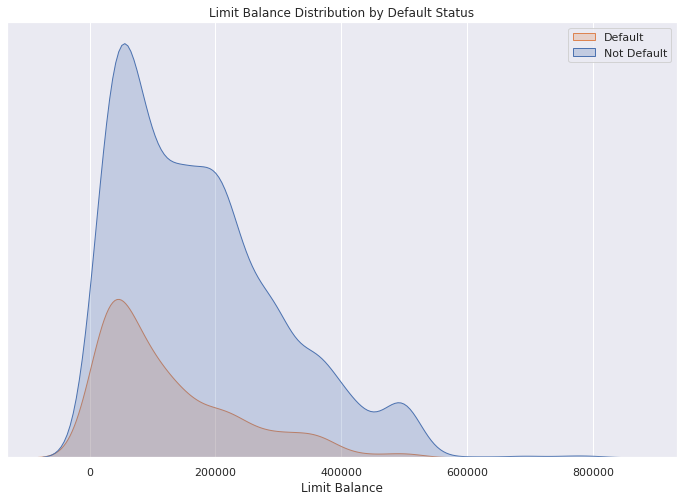

In [ ]:
# plot distribution of limit by default status
sns.set(rc={'figure.figsize':(12,8)})
sns.kdeplot(data=df_train, x='limit_balance', hue='def_pay', shade=True)
plt.title('Limit Balance Distribution by Default Status')
plt.xlabel('Limit Balance')
plt.yticks([])
plt.ylabel(None)

plt.legend(labels=['Default', 'Not Default'])
plt.show()

We can see that most clients have less than `200,000` limit balance, with the peak at around `50,000`, and the clients who have high limit balance don't seem to default that much, as seen from the bulge of profile on the right side.

## Limit Balance and Age

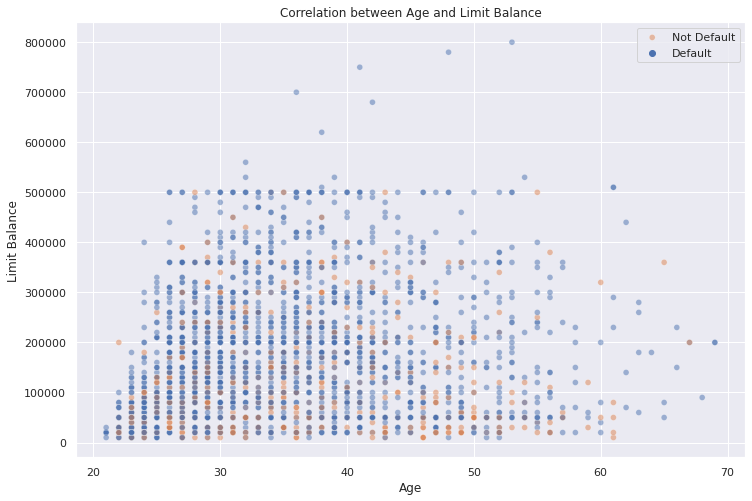

In [ ]:
# plot correlation between limit and age
sns.scatterplot(data=df_train, x='age', y='limit_balance', hue='def_pay', alpha=0.5)
plt.title('Correlation between Age and Limit Balance')
plt.xlabel('Age')
plt.ylabel('Limit Balance')

plt.legend(labels=['Not Default', 'Default'])
plt.show()

There doesn't seem to be any clear cut correlation between Age and Limit Balance

## Past Payment Status

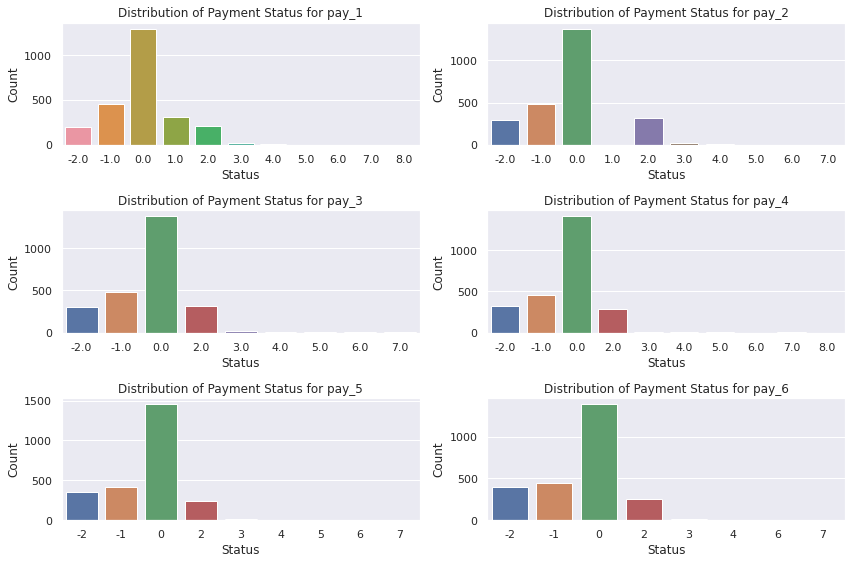

In [ ]:
# create figure for the distribution of past payment status
plt.figure(figsize=(12,8))

for i in range(6):
    col = 'pay_' + str(i + 1)
    plt.subplot(3,2,i + 1)
    sns.countplot(data=df_train, x=col)
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.title(f'Distribution of Payment Status for {col}')
    plt.tight_layout()

plt.show()

We can see that most customers duly pay their credit card bills.

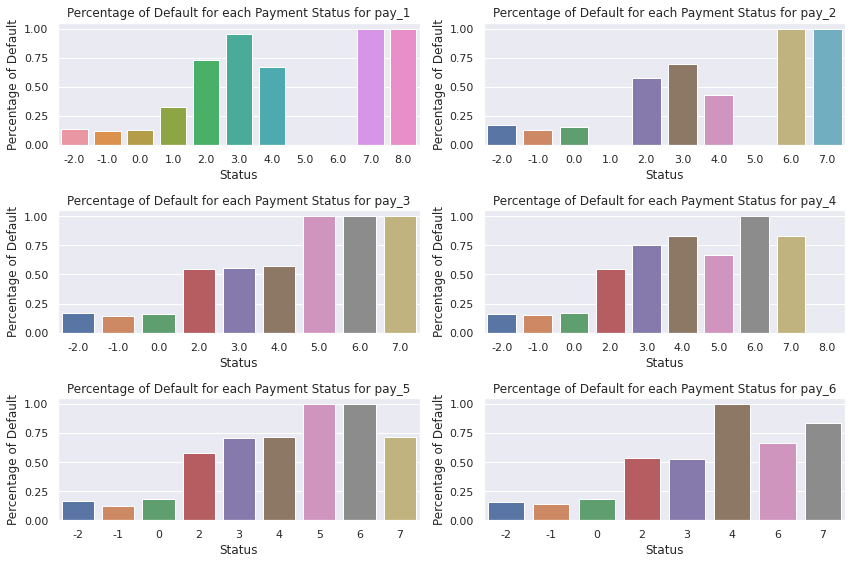

In [ ]:
# create figure for the distribution of past payment status
plt.figure(figsize=(12,8))

for i in range(6):
    col = 'pay_' + str(i + 1)
    plt.subplot(3,2,i + 1)
    sns.barplot(data=df_train, x=col, y='def_pay', ci=None)
    plt.xlabel('Status')
    plt.ylabel('Percentage of Default')
    plt.title(f'Percentage of Default for each Payment Status for {col}')
    plt.tight_layout()

plt.show()

However, customers whose payments are delayed by 2 months or more have a much higher chance of default

## Amount of Bill Statement

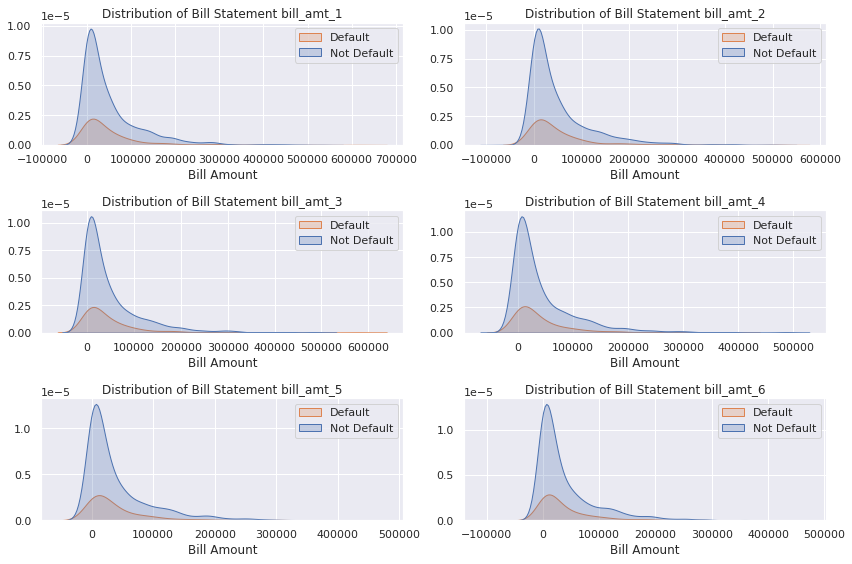

In [ ]:
# create figure for the distribution of past payment status
plt.figure(figsize=(12,8))

for i in range(6):
    col = 'bill_amt_' + str(i + 1)
    plt.subplot(3,2,i + 1)
    sns.kdeplot(data=df_train, x=col, hue='def_pay', shade=True)
    plt.xlabel('Bill Amount')
    plt.ylabel(None)
    plt.title(f'Distribution of Bill Statement {col}')
    plt.legend(labels=['Default', 'Not Default'])
    plt.tight_layout()

plt.show()

Those who have negative bill tends to have less chance of default as seen by a steep slope on the left side

## Amount of Previous Payment

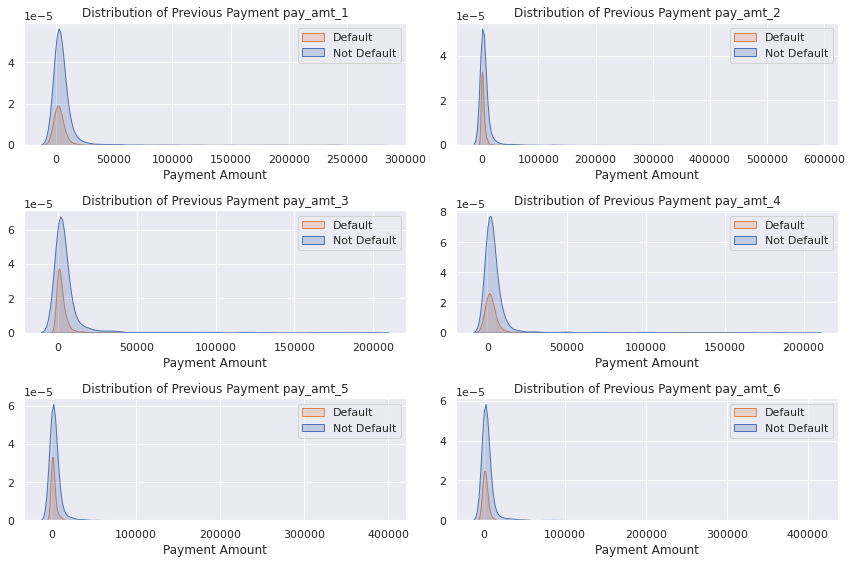

In [ ]:
# create figure for the distribution of past payment status
plt.figure(figsize=(12,8))

for i in range(6):
    col = 'pay_amt_' + str(i + 1)
    plt.subplot(3,2,i + 1)
    sns.kdeplot(data=df_train, x=col, hue='def_pay', shade=True)
    plt.xlabel('Payment Amount')
    plt.ylabel(None)
    plt.title(f'Distribution of Previous Payment {col}')
    plt.legend(labels=['Default', 'Not Default'])
    plt.tight_layout()

plt.show()

Seems like the profile is centered towards the amount 0, which means people who did not make any payment previously tend to have a higher chance of default, as seen by the steep drop on the left side of the profile

# 5. Data Preprocessing

In [ ]:
# restore the train set from the backup
df_train = df_train_ori.copy()

In [ ]:
# split between features and target
X_train = df_train.drop(['def_pay'], axis=1)
y_train = df_train['def_pay'].copy()

X_test = df_test.drop(['def_pay'], axis=1)
y_test = df_test['def_pay'].copy()

## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [ ]:
# categorizing features
num_cols = [
    'limit_balance', 'age',
    'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
    'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'
]
nom_cols = ['sex', 'marital_status']
ord_cols = ['education_level', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

## Handling Outliers

In [ ]:
# check outlier summary only on numerical features
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,limit_balance,1.01,skewed,13,0.52
1,age,0.77,skewed,26,1.04
2,bill_amt_1,2.53,skewed,194,7.73
3,bill_amt_2,2.45,skewed,195,7.77
4,bill_amt_3,2.52,skewed,199,7.93
5,bill_amt_4,2.42,skewed,177,7.05
6,bill_amt_5,2.40,skewed,197,7.85
7,bill_amt_6,2.42,skewed,195,7.77
8,pay_amt_1,8.96,skewed,234,9.32
9,pay_amt_2,16.13,skewed,235,9.36


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `None`: if outliers' percentage > 15%

In [ ]:
# check outlier details
check_outlier(X_train[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,limit_balance,500000.00,-220000.00,13,0,0.52,0.0,13,0.52
1,age,60.50,8.50,26,0,1.04,0.0,26,1.04
2,bill_amt_1,167043.50,-93352.50,194,0,7.73,0.0,194,7.73
3,bill_amt_2,164132.75,-92633.25,195,0,7.77,0.0,195,7.77
4,bill_amt_3,152371.00,-85829.00,199,0,7.93,0.0,199,7.93
5,bill_amt_4,144290.50,-82017.50,177,0,7.05,0.0,177,7.05
6,bill_amt_5,131991.00,-75817.00,197,0,7.85,0.0,197,7.85
7,bill_amt_6,129914.50,-75501.50,195,0,7.77,0.0,195,7.77
8,pay_amt_1,11106.25,-5027.75,234,0,9.32,0.0,234,9.32
9,pay_amt_2,11000.00,-5000.00,235,0,9.36,0.0,235,9.36


Observing the data, all features are right skewed and for both the bill amount and payment amount, these are features I don't think should be handled since these are monetary values and represent the amount of billing and payment the clients. The outliers just represent the wealthy clients. Therefore, I'm going to leave them alone

The same treatment for `limit_balance` and `age` as they have a similar nature

## Handling Missing Values

In [ ]:
# check missing values in train set
X_train.isna().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_1              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [ ]:
# check missing values in train target
y_train.isna().sum()

0

In [ ]:
# check missing values in test set
X_test.isna().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_1              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [ ]:
# check missing values in test target
y_test.isna().sum()

0

Great! There are no missing values in train nor test features and target

## Feature Selection

### Heatmap Correlation Matrix for Numerical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

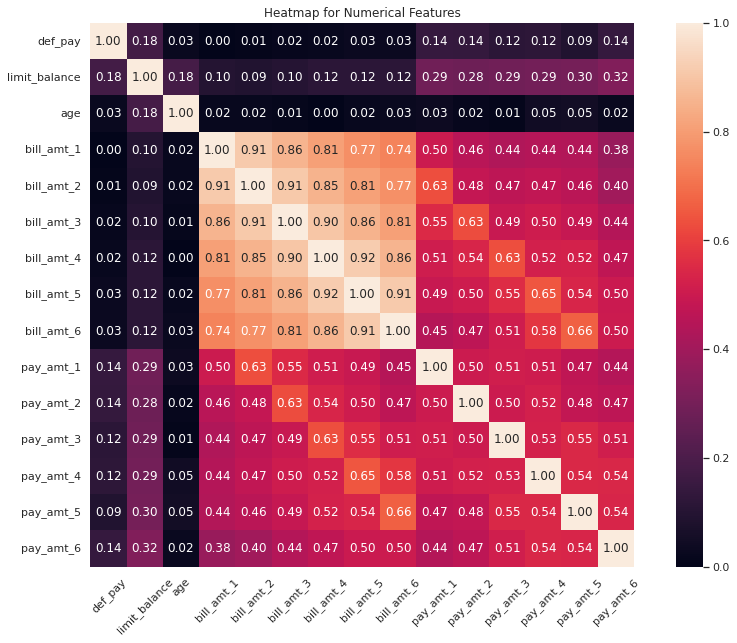

In [ ]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([y_train, X_train[num_cols]], axis=1).corr('spearman').abs(),
    annot=True, vmin=0, vmax=1, fmt='.2f', square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Heatmap for Numerical Features')

plt.show()

- We can see there are high correlation amongst `bill_amt_x` features
- There are moderate corelation amongst `pay_amt_x` features and also between `pay_amt_x` and `bill_amt_x`
- Our target label actually does not really have any particularly high correlation towards any features, the highest of which is `limit_balance`, where we already found out during the EDA that clients with high limit balance don't seem to default that much
- Since we do not really have any features that stand out, I'm going to use all features as predictors

### Heatmap Correlation Matrix for Categorical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

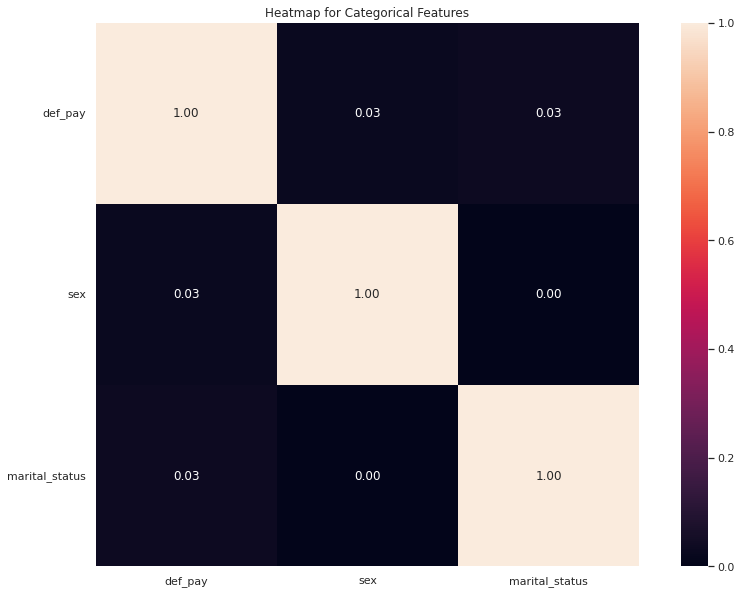

In [ ]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([y_train, X_train[nom_cols]], axis=1).corr('spearman').abs(),
    annot=True, vmin=0, vmax=1, fmt='.2f', square=True)
plt.yticks(rotation=0)
plt.title('Heatmap for Categorical Features')

plt.show()

- There are low spearman correlations amongst features and target
- However, since we do not really have any features that stand out, I'm going to use all features as predictors

### Heatmap Correlation Matrix for Ordinal Features

We look at the Spearman's correlation matrix to find out the relation between features and target

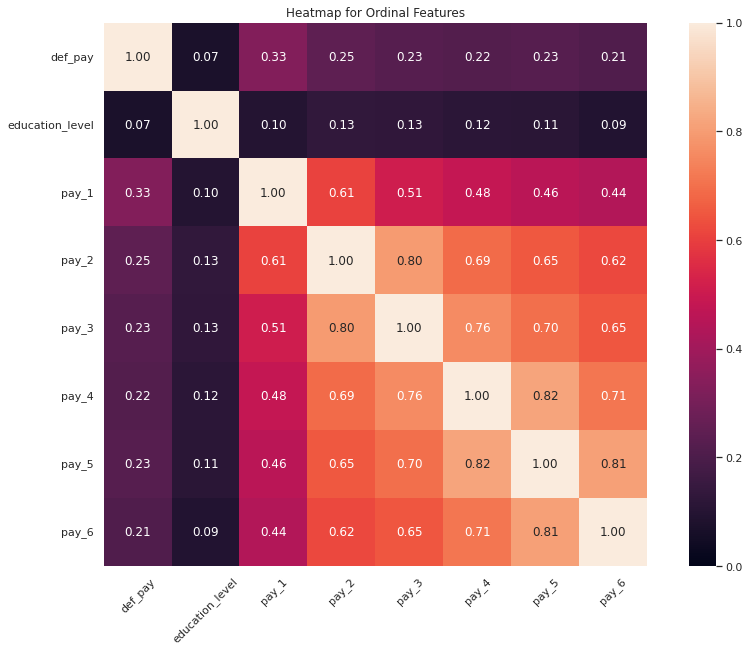

In [ ]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([y_train, X_train[ord_cols]], axis=1).corr('spearman').abs(),
    annot=True, vmin=0, vmax=1, fmt='.2f', square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Heatmap for Ordinal Features')

plt.show()

- There are quite a moderate correlations between the `pay_x` features and the target, at least higher than any in the numerical and categorical features
- However, we can also see that those features tend to be dependent amongst each other
- Still, since we do not really have any features that stand out, I'm going to use all features as predictors

### List of Features

These are the predictors we're going to use

In [ ]:
# print out list of predictors
print('Numerical Features:')
print(num_cols)
print('=' * 50)
print('Categorical Features:')
print(nom_cols)
print('=' * 50)
print('Ordinal Features:')
print(ord_cols)

Numerical Features:
['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
Categorical Features:
['sex', 'marital_status']
Ordinal Features:
['education_level', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


### Create Pipeline

Create a pipeline based on how we would engineer the features, whether to scale or to encode
- We will create multiple pipeline for scaling because each features and each models require different procedures in which we handle it
- All categorical features will use one hot encoder
- Ordinal features which 

In [ ]:
# create pipeline for standardization
std_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

# create pipeline for min max scaling
min_max_pipe = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

# create pipeline for normalizer
power_pipe = Pipeline([
    ('power_transformer', PowerTransformer())
])

# create pipeline for robust scaler
robust_pipe = Pipeline([
    ('robust_scaler', RobustScaler())
])

# create pipeline for categorical features
nom_pipe = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

### Create Column Transformer

Create a `ColumnTransformer` object based on the pipeline we have created

In [ ]:
# create column transformer object using standard scaler
ct_std = ColumnTransformer([
    ('num', std_pipe, num_cols),
    ('nom', nom_pipe, nom_cols),
    ('ord', 'passthrough', ord_cols)
])

# create column transformer object using min max scaler
ct_mm = ColumnTransformer([
    ('num', min_max_pipe, num_cols),
    ('nom', nom_pipe, nom_cols),
    ('ord', 'passthrough', ord_cols)
])

# create column transformer object using power transform
ct_pt = ColumnTransformer([
    ('num', power_pipe, num_cols),
    ('nom', nom_pipe, nom_cols),
    ('ord', 'passthrough', ord_cols)
])

# create column transformer object using robust scaler
ct_rs = ColumnTransformer([
    ('num', robust_pipe, num_cols),
    ('nom', nom_pipe, nom_cols),
    ('ord', 'passthrough', ord_cols)
])


# 6. Model Definition

- Target: Predicting whether the next month the client will default or not

    The target that we're going to predict is a label, which means we are going to make a classification model.
    We are going to predict whether a client would default or not. In this case, we want to minimize the situation in which we incorrectly predicts a client as not default (when the client is in fact default), or as in the statistical term, **False Negative**

- Predictors: The features I'm going to use are
    - Numerical Features:
        - ['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
    - Categorical Features:
        - ['sex', 'marital_status']
    - Ordinal Features:
        - ['education_level', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

- Models: The Supervised Learning Algorithms I'm going to test
    - Logistic Regression
    - Support Vector Machine
    - Decision Tree
    - Random Forest
    - KNN
    - Naive Bayes
    - AdaBoost

## Logistic Regression

I'm going to use PowerTransformer for this model since the numerical feature is skewed

In [ ]:
# declare logreg model
logreg = LogisticRegression(random_state=random_state)

# create pipeline for logreg model
pipe_logreg = Pipeline([
    ('ct', ct_pt),
    ('logreg', logreg)
])

## Support Vector Machine (SVM)

I'm going to use MinMaxScaler for this model since the numerical feature is skewed

In [ ]:
# declare svm model
svm = SVC(random_state=random_state)

# create pipeline for svm model
pipe_svm = Pipeline([
    ('ct', ct_mm),
    ('svm', svm)
])

## Decision Tree

I'm going to use MinMaxScaler for this model since the numerical feature is skewed

In [ ]:
# declare decision tree model
dt = DecisionTreeClassifier(random_state=random_state)

# create pipeline for decision tree model
pipe_dt = Pipeline([
    ('ct', ct_mm),
    ('dt', dt)
])

## Random Forest

I'm going to use MinMaxScaler for this model since the numerical feature is skewed

In [ ]:
# declare random forest model
rf = RandomForestClassifier(random_state=random_state)

# create pipeline for random forest model
pipe_rf = Pipeline([
    ('ct', ct_mm),
    ('rf', rf)
])

## KNN

I'm going to use MinMaxScaler for this model since the numerical feature is skewed

In [ ]:
# declare knn model
knn = KNeighborsClassifier()

# create pipeline for knn model
pipe_knn = Pipeline([
    ('ct', ct_mm),
    ('knn', knn)
])

## Naive Bayes

I'm going to use MinMaxScaler for this model since the numerical feature is skewed

In [ ]:
# declare naive bayes model
nb = GaussianNB()

# create pipeline for naive bayes model
pipe_nb = Pipeline([
    ('ct', ct_mm),
    ('nb', nb)
])

## AdaBoost

I'm going to use MinMaxScaler for this model since the numerical feature is skewed

In [ ]:
# declare ada boost model
ada = AdaBoostClassifier(random_state=random_state)

# create pipeline for ada boost model
pipe_ada = Pipeline([
    ('ct', ct_mm),
    ('ada', ada)
])

# 7. Model Training

In [ ]:
# create a dict containing the name of the algorithm and its pipeline
models = {
    'logreg': pipe_logreg,
    'svm': pipe_svm,
    'dt': pipe_dt,
    'rf': pipe_rf,
    'knn': pipe_knn,
    'nb': pipe_nb,
    'ada': pipe_ada
}

## Cross Validating Base Models

Since the dataset is imbalance, we are going to evaluate our models based on **F1 Score**\
It's also important that we reduce the number of *False Negatives*, hence a high **Recall** is also important

In [ ]:
# create a dict to store the cross validation scores
cv_results = {
    'models': [],
    'f1_score_mean': [],
    'f1_score_std': [],
    'recall_score_mean': [],
    'recall_score_std': []
} 

# loop over each each models and perform cross validation
for name, model in models.items():
    # fit the model
    model.fit(X_train, y_train)
    # get cross validation scores
    scores = cross_validate(
        model, X_train, y_train,
        scoring=['f1_weighted', 'recall'],
        cv=5
    )

    # store the cross validation scores
    cv_results['models'].append(name)
    cv_results['f1_score_mean'].append(scores['test_f1_weighted'].mean().round(2))
    cv_results['f1_score_std'].append(scores['test_f1_weighted'].std().round(4))
    cv_results['recall_score_mean'].append(scores['test_recall'].mean().round(2))
    cv_results['recall_score_std'].append(scores['test_recall'].std().round(4))

# create a dataframe from the dict
cv_results_df = pd.DataFrame(cv_results)

# 8. Model Evaluation

In [ ]:
# display the dataframe sorted by f1 score
cv_results_df.sort_values(by=['f1_score_mean', 'recall_score_mean'], ascending=False)

,models,f1_score_mean,f1_score_std,recall_score_mean,recall_score_std
1,svm,0.82,0.01,0.40,0.03
3,rf,0.81,0.01,0.39,0.03
4,knn,0.80,0.02,0.39,0.03
6,ada,0.80,0.02,0.37,0.05
0,logreg,0.79,0.01,0.30,0.02
2,dt,0.74,0.02,0.43,0.05
5,nb,0.29,0.02,0.94,0.02


- Based on the cross validation score of `f1_weighted` and `recall`, we can see that **SVM, Random Forest, and KNN** are the top 3
- Though we actually have an anomaly in the **Gaussian Naive Bayes** algorithm where recall score is `0.94`, way higher than the others. This phenomena however does not seem to represent the dataset, since Naive Bayes assume that there are no dependency between each features, while we know from the EDA that there are high correlations amongst the `bill_amt_x` features. Therefore, I'm not going to further dive into this model
- For this research, because of time constraint and resources, we are only going to finetune only one of our algorithm
- In this case, I'm going to choose **SVM**. However, be mindful that the other top three algorithms, such as **Random Forest** and **KNN**, should also be further delved into

## Hyperparameter Tuning

I'm going to run hyperparameter tuning using Grid Search only on SVM model.\
The parameter I'm going to tune is **Regularization** and **Kernel Coefficient**

In [ ]:
# create parameter grid for svm grid search
params_svm = {
    'svm__C': [0.1, 1, 10, 100, 1000],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10]
}

In [ ]:
# create grid search object for svm
grid_svm = GridSearchCV(pipe_svm, params_svm, cv=3, scoring='f1_weighted')

In [ ]:
%%time

# perform grid search
grid_svm.fit(X_train, y_train)

CPU times: user 20.6 s, sys: 0 ns, total: 20.6 s
Wall time: 20.6 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('min_max_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['limit_balance',
                                                                          'age',
                                                                          'bill_amt_1',
                                                                          'bill_amt_2',
                                                                          'bill_amt_3',
                                                                          'bill_amt_4',
                                                                          'bill_amt_5',
                                                                          'bill_amt_6',
                                                                          'pay_amt_1',
                                                                          'pay_amt_2',
                                                                          'pay_amt_3',
                                                                          'pay_amt_4',
                                                                          'pay_amt_5',
                                                                          'pay_amt_6']),
                                                                        ('nom',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'marital_status']),
                                                                        ('ord',
                                                                         'passthrough',
                                                                         ['education_level',
                                                                          'pay_1',
                                                                          'pay_2',
                                                                          'pay_3',
                                                                          'pay_4',
                                                                          'pay_5',
                                                                          'pay_6'])])),
                                       ('svm', SVC(random_state=42))]),
             param_grid={'svm__C': [0.1, 1, 10, 100, 1000],
                         'svm__gamma': [0.001, 0.01, 0.1, 1, 10]},
             scoring='f1_weighted')

In [ ]:
# print the best parameters
print(f'Best parameters: {grid_svm.best_params_}')

# print the best score
print(f'Best cross-validation score: {grid_svm.best_score_:.2f}')

Best parameters: {'svm__C': 1, 'svm__gamma': 0.1}
Best cross-validation score: 0.82


In [ ]:
# assign the best estimator to the final model
final_svm = grid_svm.best_estimator_

Running this grid search resulted in:
- Around 20 seconds of runtime
- Best parameters: {'svm__C': 1, 'svm__gamma': 0.1}
- Best cross-validation score: 0.82

The best parameter for `C (Regularization)`, within our parameter grid, is `1`, which is the default one.\
The best parameter for `gamma (Kernel Coefficient)`, within our parameter grid, is `0.1`\
We will compare this parameter with the base SVM model

## Evaluate Grid Search Results

In [ ]:
# predict train set using the base model
y_pred_train_svm = pipe_svm.predict(X_train)

# predict test set using the base model
y_pred_test_svm = pipe_svm.predict(X_test)

# predict train set using the final model
y_pred_train_final_svm = final_svm.predict(X_train)

# predict test set using the final model
y_pred_test_final_svm = final_svm.predict(X_test)

In [ ]:
# prepare target names for classification report
target_names = ['Not Default', 'Default']

### Base Model Evaluation

In [ ]:
# create classification report for train set
print('SVM Classification Report Training Set')
print(classification_report(y_train, y_pred_train_svm, target_names=target_names))

# create classification report for test set
print('SVM Classification Report Testing Set')
print(classification_report(y_test, y_pred_test_svm, target_names=target_names))

SVM Classification Report Training Set
              precision    recall  f1-score   support

 Not Default       0.86      0.96      0.91      1975
     Default       0.75      0.42      0.53       536

    accuracy                           0.85      2511
   macro avg       0.80      0.69      0.72      2511
weighted avg       0.83      0.85      0.83      2511

SVM Classification Report Testing Set
              precision    recall  f1-score   support

 Not Default       0.85      0.96      0.90       349
     Default       0.71      0.39      0.50        95

    accuracy                           0.84       444
   macro avg       0.78      0.67      0.70       444
weighted avg       0.82      0.84      0.82       444



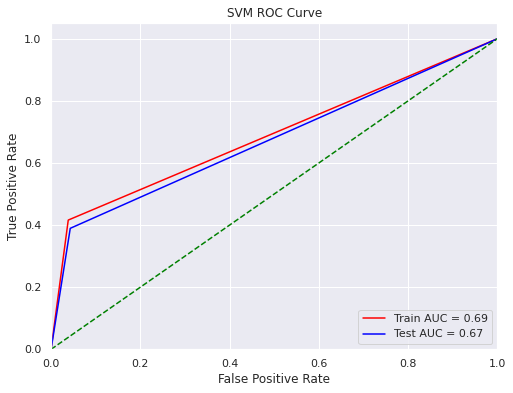

In [ ]:
# plot roc curve for train set
fpr_train_svm, tpr_train_svm, _ = roc_curve(y_train, y_pred_train_svm)
# calculate auc score for train set
roc_auc_train_svm = auc(fpr_train_svm, tpr_train_svm)

# plot roc curve for test set
fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_pred_test_svm)
# calculate auc score for test set
roc_auc_test_svm = auc(fpr_test_svm, tpr_test_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train_svm, tpr_train_svm, color='red', label=f'Train AUC = {roc_auc_train_svm:.2f}')
plt.plot(fpr_test_svm, tpr_test_svm, color='blue', label=f'Test AUC = {roc_auc_test_svm:.2f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Base Model Evaluation**
- We can see there's not much of a gap between train set and test set scores, be it *f1, accuracy, or precision and recall*, therefore the model is a good fit
- Accuracy
  - About 0.84 for the test set. However, since the data is imbalanced, we're not going to put too much thought to this metric
- Precision and Recall
  - Looking at the default target, we can see that our model is quite bad at minimizing False Negatives, as seen from the low recall score
  - That means, there are some clients that are incorrectly predicted as not default, while actually default. This is risky for the company as there might be some surprises when the clients default
  - We should aim to increase the recall score
- F1
  - The weighted f1 is quite good at 0.82
- ROC Curve
  - Our model tends to have a low FPR until the TPR (Recall) of around 0.40, that's when the FPR starts to accelerate

### Final Model Evaluation

In [ ]:
# create classification report for train set
print('SVM Tuned Classification Report Training Set')
print(classification_report(y_train, y_pred_train_final_svm, target_names=target_names))

# create classification report for test set
print('SVM Tuned Classification Report Testing Set')
print(classification_report(y_test, y_pred_test_final_svm, target_names=target_names))

SVM Tuned Classification Report Training Set
              precision    recall  f1-score   support

 Not Default       0.86      0.96      0.91      1975
     Default       0.77      0.44      0.56       536

    accuracy                           0.85      2511
   macro avg       0.82      0.70      0.73      2511
weighted avg       0.84      0.85      0.84      2511

SVM Tuned Classification Report Testing Set
              precision    recall  f1-score   support

 Not Default       0.85      0.96      0.90       349
     Default       0.73      0.39      0.51        95

    accuracy                           0.84       444
   macro avg       0.79      0.67      0.70       444
weighted avg       0.83      0.84      0.82       444



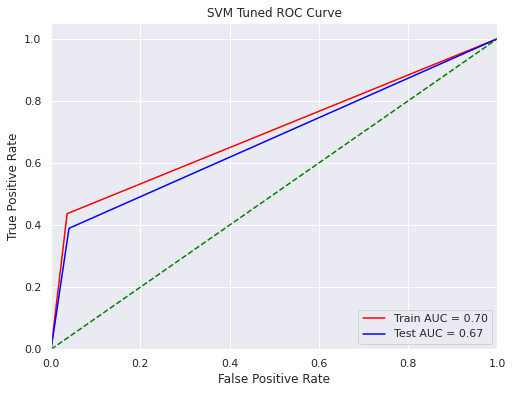

In [ ]:
# plot roc curve for train set
fpr_train_svm, tpr_train_svm, _ = roc_curve(y_train, y_pred_train_final_svm)
# calculate auc score for train set
roc_auc_train_svm = auc(fpr_train_svm, tpr_train_svm)

# plot roc curve for test set
fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_pred_test_final_svm)
# calculate auc score for test set
roc_auc_test_svm = auc(fpr_test_svm, tpr_test_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train_svm, tpr_train_svm, color='red', label=f'Train AUC = {roc_auc_train_svm:.2f}')
plt.plot(fpr_test_svm, tpr_test_svm, color='blue', label=f'Test AUC = {roc_auc_test_svm:.2f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Tuned ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Final Model Evaluation**
- The data is still a good fit, as seen that there's not much of a gap between train set and test set scores, be it *f1, accuracy, or precision and recall*
- Accuracy
  - About 0.84 for the test set. It's the same score as the base model. However, since the data is imbalanced, we're not going to put too much thought to this metric
- Precision and Recall
  - There is not much change from the base model
  - Our model is still quite bad at minimizing False Negatives, as seen from the low recall score of 0.39 in the `default` target name
  - There is an increase of precision score from the base model though. This is not our aim, but we do not mind an increase in precision so long as it did not impact the recall score negatively
- F1
  - The weighted f1 is stayed the same at 0.82
- ROC Curve
  - The test AUC remains relatively the same compared to the base model
  - However, we see an increase in the train AUC
  - The TPR value is still around the 0.40 mark until the FPR starts to accelerate

#### Analysis
1. We can conclude that using `gamma=0.1` as a hyperparameter resulted in a slightly better model.
2. We successfully increased the precision score marginally without decreasing the precision score
3. However, the model is still terrible as it still has a high recall value, we should aim to improve this later on
4. That means we are still bad at detecting clients that are default, which is our main objective to improve
5. This means that the use of all features as predictors, using the current SVM models is not yet sufficient to make a solid prediction

## Save The Final Model

In [ ]:
# prepare directory for saving model
model_dir = 'models'
model_name = 'svm_model.pkl'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

# save model
joblib.dump(final_svm, Path(model_dir, model_name))

['models/svm_model.pkl']

# 9. Model Inference

## Load The Model

In [ ]:
# model location
model_dir = 'models'
model_name = 'svm_model.pkl'
model_path = Path(model_dir, model_name)

# load model
final_svm = joblib.load(model_path)

In [ ]:
# display inference set
df_inf.head()

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,def_pay
0,160000.0,2,4,2,32.0,-1.0,-1.0,-1.0,-1.0,-1,...,3181.0,4998.0,1250.0,5726.0,5037.0,3182.0,5000.0,1252.0,749.0,0
1,20000.0,1,2,1,29.0,1.0,-2.0,-2.0,-2.0,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,150000.0,2,4,2,33.0,0.0,-1.0,-1.0,-1.0,-1,...,1141.0,1067.0,1128.0,237.0,1426.0,1141.0,1067.0,1200.0,1150.0,0
3,100000.0,1,3,1,46.0,2.0,2.0,2.0,0.0,0,...,18036.0,18446.0,18840.0,1300.0,0.0,700.0,700.0,700.0,800.0,1
4,140000.0,2,4,2,34.0,-1.0,-1.0,-2.0,-2.0,-1,...,0.0,6400.0,11400.0,0.0,0.0,0.0,6400.0,5000.0,1000.0,0


## Inferencing

In [ ]:
%%time

# predict inference set using the final model
y_pred_inf_svm = final_svm.predict(df_inf)

CPU times: user 16.2 ms, sys: 756 µs, total: 17 ms
Wall time: 14.5 ms


In [ ]:
# create dataframe with predictions
df_inf['pred_svm'] = y_pred_inf_svm

# display inference set
df_inf

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,def_pay,pred_svm
0,160000.0,2,4,2,32.0,-1.0,-1.0,-1.0,-1.0,-1,...,4998.0,1250.0,5726.0,5037.0,3182.0,5000.0,1252.0,749.0,0,0
1,20000.0,1,2,1,29.0,1.0,-2.0,-2.0,-2.0,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,150000.0,2,4,2,33.0,0.0,-1.0,-1.0,-1.0,-1,...,1067.0,1128.0,237.0,1426.0,1141.0,1067.0,1200.0,1150.0,0,0
3,100000.0,1,3,1,46.0,2.0,2.0,2.0,0.0,0,...,18446.0,18840.0,1300.0,0.0,700.0,700.0,700.0,800.0,1,1
4,140000.0,2,4,2,34.0,-1.0,-1.0,-2.0,-2.0,-1,...,6400.0,11400.0,0.0,0.0,0.0,6400.0,5000.0,1000.0,0,0
5,50000.0,2,3,1,34.0,0.0,0.0,0.0,0.0,2,...,1582.0,1099.0,1538.0,1575.0,1582.0,593.0,242.0,17012.0,0,0
6,120000.0,2,3,2,27.0,0.0,0.0,0.0,0.0,0,...,10388.0,13316.0,1137.0,1514.0,1069.0,278.0,3000.0,0.0,1,0
7,40000.0,2,3,1,25.0,0.0,0.0,0.0,0.0,0,...,41389.0,40628.0,1950.0,4300.0,2000.0,2938.0,0.0,3700.0,1,0
8,180000.0,2,3,1,38.0,-1.0,2.0,2.0,-1.0,0,...,5181.0,5181.0,0.0,0.0,8941.0,0.0,0.0,0.0,1,0
9,50000.0,2,4,2,25.0,0.0,0.0,0.0,0.0,0,...,31003.0,29693.0,1870.0,2500.0,3017.0,1060.0,1300.0,2000.0,0,0


Model successfully run on inference dataset

# 10. Conclusion

## On EDA
- Most clients are not default the next month. There's around 1 to 4 ratio of clients who are default compared to ones who are not default
- There are more female clients compared to male clients. However, male clients have a slightly higher chance of default
- Most of our clients finished University and Grad School
- People who attended Grad School, seems to have less chance of default compared to those who attended University or High School.
- The label for others also have a lower percentage of default, but this is also in conjunction that there are very few clients in this label, meaning the selection process to give out credit card to this label must be must be tight as well
- Most of our clients are either married or single. Married people have a slightly higher chance of default, while divorced people have a lower chance of default, but there are only a few of them in the data, so this may not be enough to make a conclusion
- Most clients are around the age of 30. There's no difference between the distribution of age between not default and default clients
- We can see that most clients have less than `200,000` limit balance, with the peak at around `50,000`, and the clients who have high limit balance don't seem to default that much
- There doesn't seem to be any clear cut correlation between Age and Limit Balance
- Most customers duly pay their credit card bills. However, customers whose payments are delayed by 2 months or more have a much higher chance of default
- Those who have negative bill tends to have less chance of default
- People who did not make any payment previously tend to have a higher chance of default
- We can see there are high correlation amongst `bill_amt_x` features
- There are moderate corelation amongst `pay_amt_x` features and also between `pay_amt_x` and `bill_amt_x`
- There are quite a moderate correlations between the `pay_x` features and the target, at least higher than any in the numerical and categorical features

## On Modeling
- **SVM, Random Forest, and KNN** are the top models based on *f1_weighted and recall*
- However, based on *recall* alone, **Naive Bayes** algorithm resulted in a very high recall score, double the others. This phenomena however does not seem to represent the dataset, since Naive Bayes assume that there are no dependency between each features, while we know from the EDA that there are high correlations amongst the `bill_amt_x` features.
- The best parameter found for `gamma (Kernel Coefficient)` of the **SVM model**, within our parameter grid, is `0.1`
We will compare this parameter with the base SVM model
- The model is still terrible as it has a low *recall* value. Which is quite important in this business. We may miss some clients that are actually default
- In terms of *precision* and *f1* however, the model is quite decent, however *recall* is more important
- This means that the use of all features as predictors, using the current SVM models is not yet sufficient to make a solid prediction

## Implication
- Default detection is important in the business of credit card issuer
- As a credit card issuer, we need to be able to detect which clients would default. Detecting the default clients is way more important than detecting the non default clients.
- It's okay to detect a client as default even though they turns out to not be
- The opposite however, is dangerous, as the company might not be able to take the risk mitigation needed towards these defaulting clients that may impact the cash flow of the company negatively and consecutively, the bottom line
- Therefore, our model that is still terrible at detecting those few detrimental clients need to be further improved

## Future Improvement
- Consider running hyperparameter tuning on other models as well
- Consider using other methods of feature scaling on numerical data
- Consider dropping some of the correlated features such as one of the `bill_amt_X` features
- Consider trimming and capping some of the outliers
- Aim to further increase recall to be able to detect the default status even more
- Consider running the **Naive Bayes** algorithm, though weird and might be overfit, churned out a high recall score during cross validation

# Conceptual Problems

1. What's the function of the `criterion` parameter in Decision Tree? Explain one of them
    - `criterion` determines how the quality of a split will be measured
    - *Entropy* measures the randomness, as in the impurity of the split. Its value ranges from 0 to 1, with `0` being a pure split (well ordered) and `1` being a totally impure split.
    - *Entropy* tends to produce slightly more balanced trees compared to *Gini*, however it takes slightly slower to run
2. What's the purpose of `pruning` in Tree model?
    - Pruning is used to reduce the size of the tree model by removing unnecessary nodes.
    - Pruning makes the model simpler and reduces overfitting, thereby improving predictive accuracy
3. How to choose the optimal `K` in KNN?
    - We need to run our KNN models several times with different K and choose the ones which has the lowest error metrics while still maintaining a good fit
4. Explain what you understand regarding `Cross Validation`!
    - `Cross Validation` splits the data set (usually run on train set) into smaller training set and a validation set. It then trains the model against the smaller training set and evaluate it against the validation set.
    - The split is usually done into a number of distinct subsets called *folds*, then trains and evaluates each folds, resulting a list containing a number of evaluation scores
    - This is a good method to validate our model on the train set without "dirtying" the test set
5. Explain what you understand regarding `Accuracy, Precision, Recall, F1 Score`!
    - `Accuracy`
        - The ratio of correct predictions over the total number of data points
    - `Precision`
        - Calculates the ratio of *True Positives* over the *Predicted Positives*
        - A high precision score indicates that there are very few *False Positives*
    - `Recall`
        - Calculates the ratio of *True Positives* over the *Actual Positives*
        - A high recall score, indicates that there are very few *False Negatives*
    - `F1 Score`
        - The harmonic mean of precision and recall
        - It aims to combine precision and recall into one single metric
        - A better measure than accuracy since we take into account the *False Positives* and *False Negatives*, and especially more useful in imbalance datasets